# Denoiser

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
import os
from os.path import join

import random
import numpy as np
import pandas as pd
import cv2
import pickle
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import gc


from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from tensorflow.keras.models import  load_model,Model
from tensorflow.keras import applications
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2DTranspose, Reshape,Input,Dropout, Activation, Dense, GlobalMaxPooling2D,Conv2D,Flatten,MaxPooling2D,InputLayer
from tensorflow.keras.utils import to_categorical
import copy

from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras import datasets
from foolbox.attacks import LinfFastGradientAttack,LinfDeepFoolAttack
from foolbox.distances import LpDistance
from foolbox.models import TensorFlowModel
from foolbox import criteria
from sklearn.metrics import classification_report


from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import BoundaryAttack
from art.utils import load_dataset #to play with cifar images


gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)]
)

In [30]:
tf.config.run_functions_eagerly(False)

### 1. Load Data

In [31]:
(X_train, y_train), (X_test, y_test), min, max=load_dataset('cifar10')
y_test=list(map(np.argmax,y_test))

In [32]:
dict_classes={}
dict_classes[0]='airplane'
dict_classes[1]='automobile'
dict_classes[2]='bird'
dict_classes[3]='cat'
dict_classes[4]='deer'
dict_classes[5]='dog'
dict_classes[6]='frog'
dict_classes[7]='horse'
dict_classes[8]='ship'
dict_classes[9]='truck'

### 2. Load model

In [33]:
effnet_base = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
effnet_base.trainable=True
x = GlobalMaxPooling2D(name='pool_1')(effnet_base.layers[-2].output)
x = Dropout(0.2, name="dropout_2")(x)
x = Dense(32)(x)
x = Dense(10,name='fc_2')(x)
o = Activation('softmax', name='act_2')(x)
model_effnet = Model(inputs=effnet_base.input, outputs=[o])

In [34]:
training_effnet=False

if training_effnet==True:
    model_effnet.compile(
        loss='categorical_crossentropy',
        optimizer='nadam',
        metrics=['accuracy']
        )
    history = model_effnet.fit(X_train, y_train,
                  epochs=5,
                  batch_size = 128,
                  validation_split=0.1,
                  shuffle=True,
                  verbose=1)
    model_effnet.save('/media/hdd1/benchmark_adversarial_attacks/effnet_model_cifar.h5')
    
else:
    model_effnet=load_model('/media/hdd1/benchmark_adversarial_attacks/effnet_model_cifar.h5')
    

### 3.Denoiser creation and data set creation

In [35]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          Input(shape=(32, 32, 3)), 
          Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
          Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
          Flatten(),
          Dense(4096,activation='relu'),          
          Reshape((8,8,64))
            ])

        self.decoder = tf.keras.Sequential([
        Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
        Conv2DTranspose(128, kernel_size=2, strides=2, activation='relu', padding='same'),
        Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

In [36]:
def data_set_maker(model,attack, image_list, labels):
    model_to_fool = TensorFlowModel(model, bounds=(0, 255))
    success=[]
    adv_list=[]
    benign_list=[]
    adv_true_label=[]
    epsilon=[0.001]
    print('======epsilon: '+str(epsilon[0])+'======')
    for i,image in enumerate(tqdm(image_list,position=0)):
        if i!=0 and i%2000==0:
            epsilon=[epsilon[0]*10]
            print('======epsilon: '+str(epsilon[0])+'======')
        image = np.asarray(image)[:,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_fool,image,label,epsilons=epsilon)
        if bool(is_adv[0][0]) ==True:
            adv_list.append(np.array(clipped[0][0]))
            adv_true_label.append(labels[i]) 
            benign_list.append(image) 
            
    for i,image in enumerate(benign_list):
        benign_list[i]=np.squeeze(image)
        
    return(list(adv_list),list(benign_list),adv_true_label)


In [37]:
attack_deepfool=LinfDeepFoolAttack()
attack_FGSM=LinfFastGradientAttack()
(adv_list,benign_list,adv_true_label)=data_set_maker(model_effnet,attack_FGSM, X_test[:6000], y_test[:6000])

  0%|          | 0/6000 [00:00<?, ?it/s]

======epsilon: 0.001======


 33%|███▎      | 2000/6000 [15:56<31:40,  2.11it/s]

======epsilon: 0.01======


 67%|██████▋   | 4000/6000 [31:54<15:51,  2.10it/s]

======epsilon: 0.1======


100%|██████████| 6000/6000 [47:52<00:00,  2.09it/s]


In [38]:
# with open('data/adv images and benign images', 'wb') as f:
#     pickle.Pickler(f).dump(adv_list)
#     pickle.Pickler(f).dump(benign_list)
#     pickle.Pickler(f).dump(adv_true_label)

In [39]:
with open('data/adv images and benign images', 'rb') as f:
    adv_list=pickle.Unpickler(f).load()
    benign_list=pickle.Unpickler(f).load()
    adv_true_label=pickle.Unpickler(f).load()

let's add some non advsersarial images in the data set

In [40]:
adv_list.extend(X_test[6000:7000])
benign_list.extend(X_test[6000:7000])
adv_true_label.extend(y_test[6000:7000])

adv_list=np.array(adv_list)
benign_list=np.array(benign_list)
adv_true_label=np.array(adv_true_label)

indices = np.arange(len(adv_list))
random.shuffle(indices)
adv_list = adv_list[indices]
benign_list = benign_list[indices]
adv_true_label = adv_true_label[indices]

In [41]:
len(adv_list)

4627

### 4. Denoiser training

In [42]:
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(),metrics=['MeanSquaredError'])
autoencoder.fit(np.array(adv_list[:3600]),np.array(benign_list[:3600]),
                epochs=30,
                batch_size=32,
                shuffle=True)

Epoch 1/30
113/113 [==============================] - 1s 10ms/step - loss: 0.0315 - mean_squared_error: 0.0315
Epoch 2/30
113/113 [==============================] - 1s 9ms/step - loss: 0.0133 - mean_squared_error: 0.0133
Epoch 3/30
113/113 [==============================] - 1s 9ms/step - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 4/30
113/113 [==============================] - 1s 9ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 5/30
113/113 [==============================] - 1s 9ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 6/30
113/113 [==============================] - 1s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 7/30
113/113 [==============================] - 1s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 8/30
113/113 [==============================] - 1s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 9/30
113/113 [==============================] - 1s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 10/

W0126 10:26:37.720218 140016557791040 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0126 10:26:41.329081 140016557791040 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0126 10:26:41.815959 140016557791040 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0126 10:26:41.977407 140016557791040 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0126 10:26:42.156208 140016557791040 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0126 10:26:42.486794 140016557791040 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0126 10:26:43.906541 140016

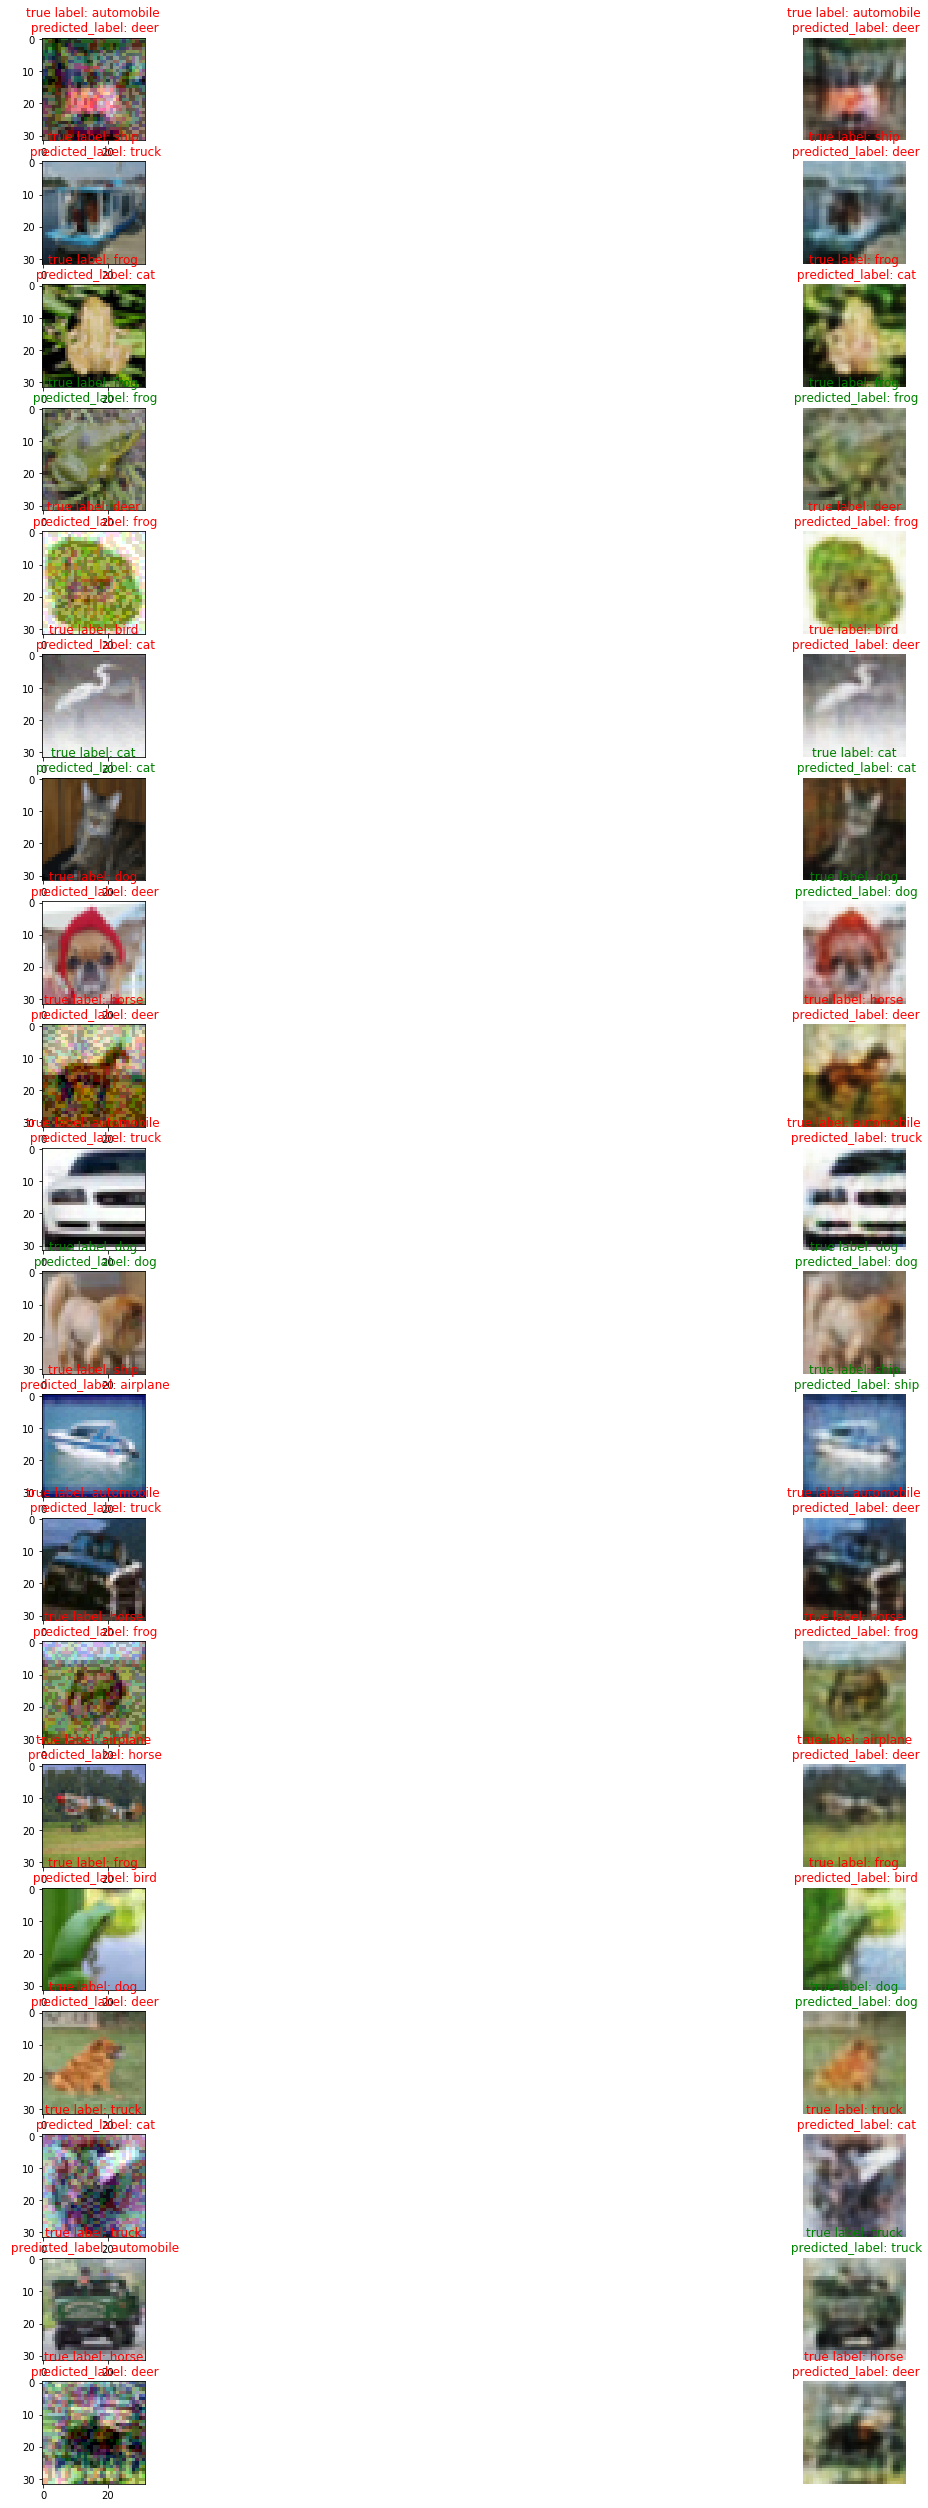

In [43]:
plt.figure(figsize=(25,45))
for i,(adv_image, true_label) in enumerate(zip(adv_list[3600:3620],adv_true_label[3600:3620])): 
   
    i=2*i
    ax = plt.subplot(20, 2, i + 1)
    plt.imshow(adv_image)
    predicted_adv_label=dict_classes[np.argmax(model_effnet.predict(np.expand_dims(adv_image,axis=0)))]
    true_label=dict_classes[true_label]
    if true_label==predicted_adv_label:
        color='green'
    else:
        color='red'
    plt.title('true label: '+str(true_label)+'\n predicted_label: '+str(predicted_adv_label),color=color)
    
    ax = plt.subplot(20, 2, i + 2)
    new_image=autoencoder.predict(np.expand_dims(adv_image,axis=0))
    predicted_label=dict_classes[np.argmax(model_effnet.predict(new_image))]
    plt.imshow(np.squeeze(new_image))
    if true_label==predicted_label:
        color='green'
    else:
        color='red'
    plt.title('true label: '+str(true_label)+'\n predicted_label: '+str(predicted_label),color=color)
    plt.axis("off")
plt.show()

Let's add the denoiser on top of the effnet_model.
Beforehand we made the denoiser not trainable

In [44]:
autoencoder.trainable=False
inputs=Input(shape=(32,32,3))
x=autoencoder(inputs)
o=model_effnet(x)

model_with_defense=Model(inputs,[o])


model_with_defense.compile(
        loss='categorical_crossentropy',
        optimizer='nadam',
        metrics=['accuracy']
        )

W0126 10:43:46.575778 140016557791040 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0126 10:43:46.862948 140016557791040 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0126 10:43:47.057652 140016557791040 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0126 10:43:47.126237 140016557791040 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


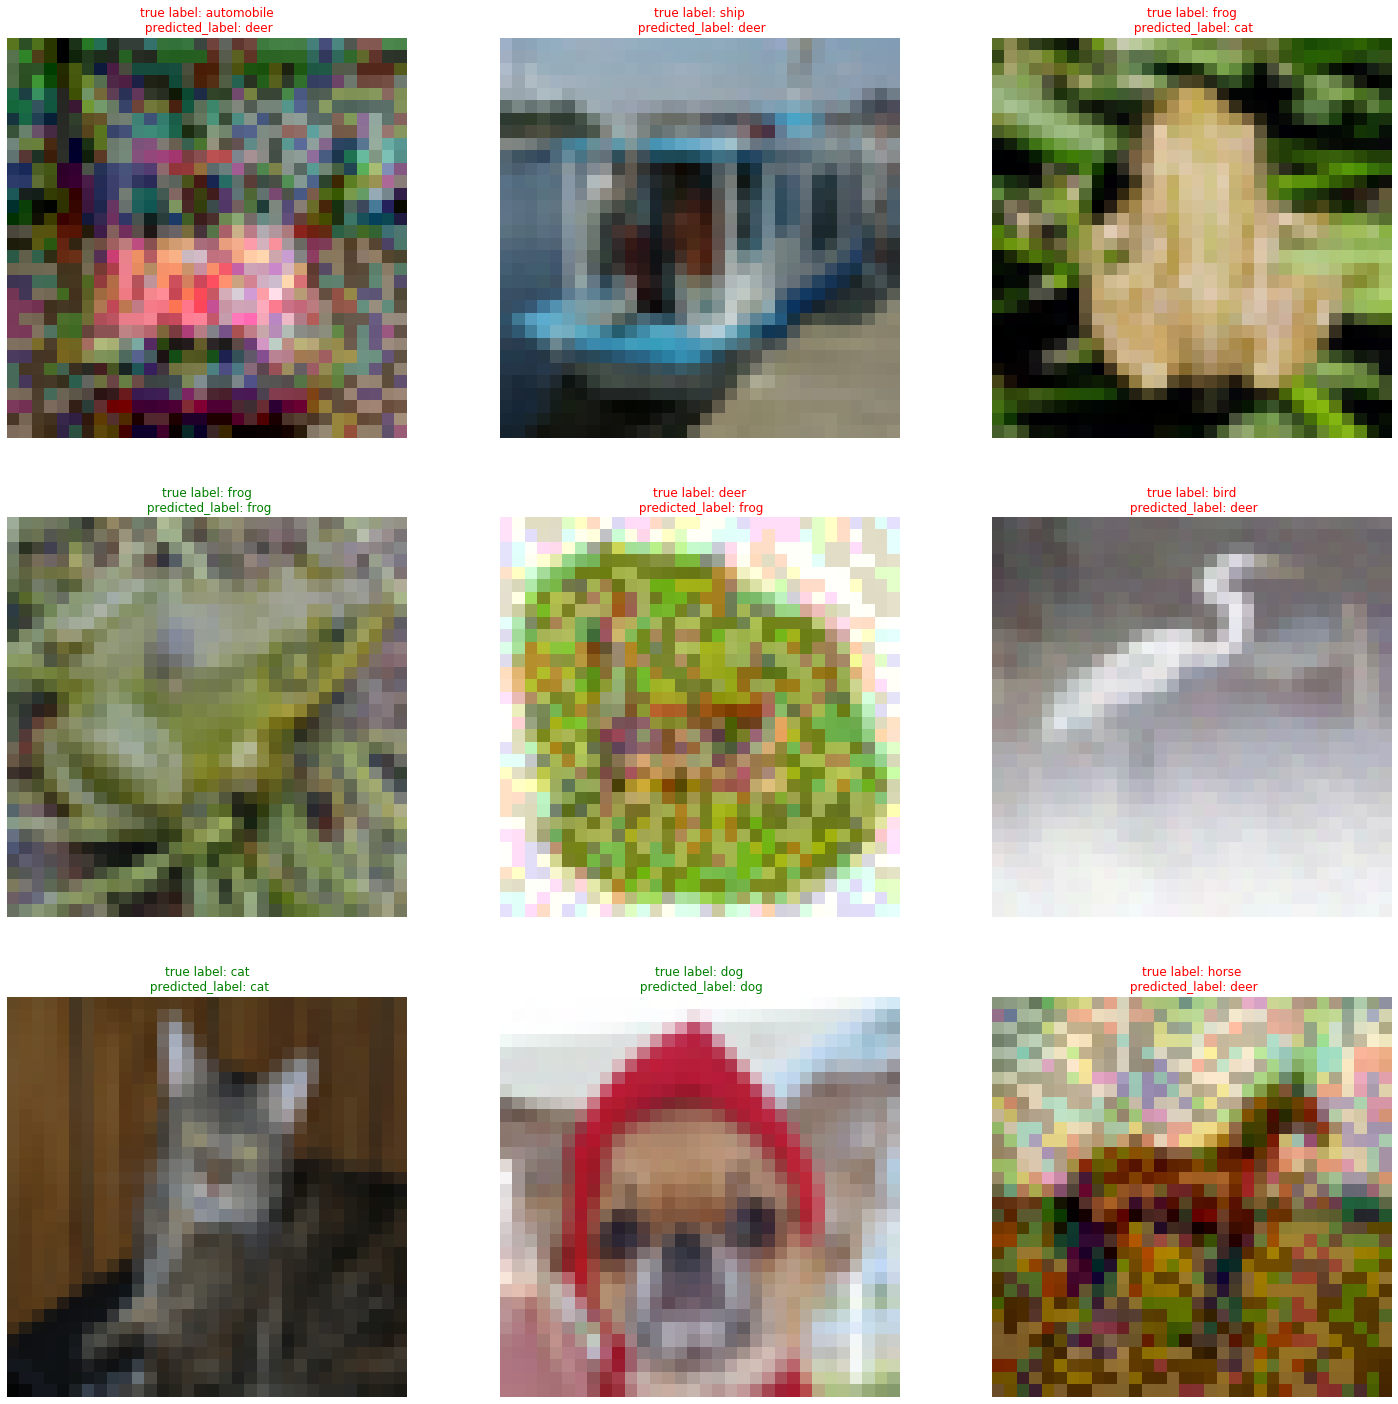

In [53]:
plt.figure(figsize=(25,25))
for i,(adv_image, true_label) in enumerate(zip(adv_list[3600:3609],adv_true_label[3600:3609])): 

    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(adv_image)
    predicted_adv_label=dict_classes[np.argmax(model_with_defense.predict(np.expand_dims(adv_image,axis=0)))]
    true_label=dict_classes[true_label]
    if true_label==predicted_adv_label:
        color='green'
    else:
        color='red'
    plt.title('true label: '+str(true_label)+'\n predicted_label: '+str(predicted_adv_label),color=color)
    
   
    plt.axis("off")
plt.show()

### 5. Useful functions

Let's define the peformances metrics

In [46]:
def DOC (x_adv_list,x_list):
    N=len(x_adv_list)
    sum=0
    for i in range (N):        
        sum+=100*np.linalg.norm(np.reshape(x_adv_list[i] - x_list[i], -1),ord=1)/np.linalg.norm(np.reshape(x_list[i], -1),ord=1)
    return(sum/N)

def succes_rate (success_list):
    success=len([i for i in success_list if i==True])
    total=len(success_list)
    return(success/total)

### 6. Attack robusteness

##### White box attack

In [80]:
def attack_performances_computer(model_to_attack,predicting_model,attack, image_list, labels,epsilon):
    model_to_attack=TensorFlowModel(model_to_attack , bounds=(0, 255))
   
    success_on_attacked_model=[]
    success_on_predicting_model=[]
    adv_list=[]
    for i,image in enumerate(tqdm(image_list,position=0)):
        image = np.asarray(image)[:,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_attack,image,label,epsilons=epsilon)
        success_on_attacked_model.append(bool(is_adv[0][0]))
        adv_list.append(np.array(clipped[0][0]))
        prediction=predicting_model.predict(np.expand_dims(clipped[0][0],axis=0))
        if np.argmax(prediction)!=labels[i]:
            success_on_predicting_model.append(True)
        else:
            success_on_predicting_model.append(False)
            
        
    DOC_attack=DOC(adv_list,image_list)
    SR_on_attacked_model=succes_rate(success_on_attacked_model)
    SR_on_predicting_model=succes_rate(success_on_predicting_model)
    return(DOC_attack,SR_on_attacked_model,SR_on_predicting_model)


In [81]:
def attack_runner(model_to_attack,predicting_model,image_list, labels_list, epislons_list):   
    
    
    attack_FGSM=LinfFastGradientAttack()
    
   

    SR_FGSM_dic={}  
    SR_FGSM_dic_with_defense={}


    for epsilon in epislons_list:
        print('======'+'epislon: '+str(epsilon)+'======')
        DOC_FGSM,SR_FGSM,SR_FGSM_with_defense=attack_performances_computer(model_to_attack,predicting_model,attack_FGSM, image_list, labels_list,[epsilon])
              
        SR_FGSM_dic[DOC_FGSM]=SR_FGSM
        SR_FGSM_dic_with_defense[DOC_FGSM]=SR_FGSM_with_defense
        
    return(SR_FGSM_dic,SR_FGSM_dic_with_defense)

In [82]:
# model_to_fool = TensorFlowModel(model_with_defense , bounds=(0, 255))
SR_FGSM_dic_without_defense,SR_FGSM_dic_with_defense=attack_runner(model_effnet,model_with_defense,X_test[7000:7100], y_test[7000:7100], [0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1])

    

  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.0005======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.001======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.005======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.01======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.05======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


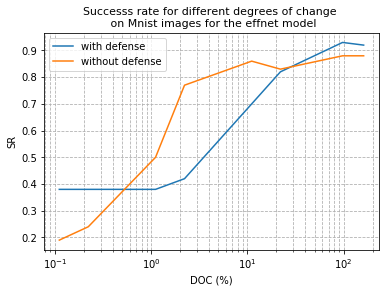

In [83]:
plt.plot(list(SR_FGSM_dic_with_defense.keys()),list(SR_FGSM_dic_with_defense.values()),label='with defense')
plt.plot(list(SR_FGSM_dic_without_defense.keys()),list(SR_FGSM_dic_without_defense.values()),label='without defense')
plt.xscale('log')
plt.grid(True,which="both", linestyle='--')
plt.title('Successs rate for different degrees of change \n on Mnist images for the effnet model',fontsize=11)
plt.xlabel('DOC (%)')
plt.ylabel('SR')
plt.legend(loc='upper left')
